In [1]:
import sys
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

file = pd.read_csv('Cancer Dataset.csv')

df = pd.DataFrame(file)
if df.isnull().values.any():
    cols_with_null = df.columns[df.isnull().any()].tolist()
    if len(cols_with_null) > 0:
        df = df.bfill().ffill()
df.drop_duplicates(inplace = True)

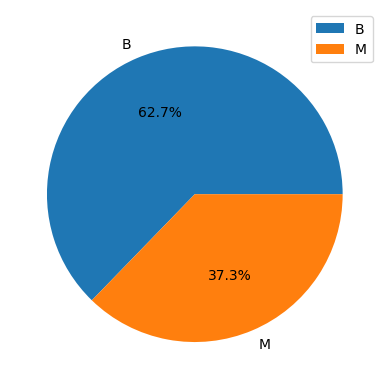

In [2]:
ch = df['diagnosis'].value_counts()
plt.pie(ch, labels = ch.index, autopct = '%.1f%%')
plt.legend()
plt.show()

In [3]:
X = df.drop('diagnosis', axis = 1)
Y = df['diagnosis']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)

model = linear_model.LogisticRegression(max_iter = 1000)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

In [4]:
print(accuracy_score(Y_test, Y_pred) * 100)

98.24561403508771


In [9]:
class ModelWrapper(tf.Module):
    def __init__(self, sklearn_model):
        super().__init__()
        self.model = sklearn_model

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float32, name = "x")])
    def predict(self, x):
        def sklearn_predict(x_np):
            preds = self.model.predict(x_np)
            return preds.astype(np.int64)
        
        preds = tf.py_function(func=sklearn_predict, inp=[x], Tout=tf.int64)
        preds.set_shape([None])  
        return preds

wrapped_model = ModelWrapper(model)
tf.saved_model.save(wrapped_model, 'cancer_detection_model', signatures=wrapped_model.predict) 

INFO:tensorflow:Assets written to: cancer_detection_model\assets


INFO:tensorflow:Assets written to: cancer_detection_model\assets


In [ ]:
loaded = tf.saved_model.load('saved_sklearn_model')
print(list(loaded.signatures.keys()))

file1 = pd.read_csv('Cancer Test Dataset.csv')
df = pd.DataFrame(file1)
if df.isnull().values.any():
    cols_with_null = df.columns[df.isnull().any()].tolist()
    if len(cols_with_null) > 0:
        df = df.bfill().ffill()
df.drop_duplicates(inplace = True)
X = tf.convert_to_tensor(df.drop('diagnosis', axis = 1), dtype = tf.float32)
Y = df['diagnosis']
predictions = loaded.signatures['serving_default'](x = X)
#print(list(predictions.values())[0].shape)

In [122]:
print(Y.shape)
print(accuracy_score(Y, list(predictions.values())[0]) * 100)


(20,)
100.0


In [126]:
print(X_train.columns)


Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
